In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.config import paths, params


cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [20]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

In [21]:
import json

CONFIG_PATH = os.path.join('cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/config0.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
ranges['y'] = [-100, 100]
feature_range = (-1, 1)

print(inference_list)
print(ranges)

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '1000s_y1Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'summ_stats0.npz')  # LFP and labels

summ_stats   = np.load(LFP_PATH)['x']
labels = np.load(LFP_PATH)['y']

labels[:,0] = np.load(LFP_PATH)['ys']

df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
# display(df_la)
df_bet_la = df_la[df_la['y'].between(-100, 100)].index.values

labels = labels[df_bet_la,:]
summ_stats = summ_stats[df_bet_la,:]
display(df_la[df_la['y'].between(-100, 100)])

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
{'x': [-50, 50], 'y': [-100, 100], 'z': [20.0, 200.0], 'alpha': [0, 3.141592653589793], 'h': [-1.0, 1.0], 'phi': [-3.141592653589793, 3.141592653589793], 'd': [20.0, 200.0], 'theta': [-1.0471975511965976, 1.0471975511965976], 'r_s': [7.0, 12.0], 'l_t': [20.0, 800.0], 'r_t': [0.6, 1.8], 'r_d': [0.1, 0.8], 'r_tu': [0.1, 0.8], 'l_d': [100.0, 300.0]}


,y,d,theta,h,phi,r_s,l_t,r_t
889,-99.122356,158.567656,-0.282863,-0.602610,-2.723164,9.146831,298.260572,1.082463
235,-96.539589,55.502291,-0.605595,-0.803406,2.010273,8.936617,317.455527,1.548819
215,-96.525035,177.234074,-0.398543,0.908610,0.578021,10.245818,52.762555,0.877110
502,-94.839032,52.888206,0.047551,-0.877754,-2.328690,10.672544,101.318815,1.456209
77,-93.292155,190.809861,-0.013818,-0.501318,-1.984062,11.886048,486.295251,1.207861
...,...,...,...,...,...,...,...,...
504,95.969824,181.585718,-0.649512,0.844816,2.558533,7.377579,87.041720,1.068007
269,97.727256,153.988531,0.297392,0.571833,-3.131668,11.248819,737.365449,1.403897
901,97.880291,136.032043,0.393296,0.626986,3.000355,8.189393,628.632922,1.299157
433,98.605421,103.316206,-0.322245,0.700942,2.492166,8.062453,178.569475,0.602166


In [22]:
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

def test_max():
    lp = os.path.join(TRIAL_PATH, 'lfp0.npz')  # LFP and labels
    lfp = np.load(lp)['x']
    print(lfp.shape)

    dp = 'cell_inference/resources/invivo'
    invp = os.path.join(dp, 'all_cell_LFP_2D.h5')

    with h5py.File(invp, "r") as f:
        c = f['coord'][:]
        d = f['data'][:]  # time x channels x samples

    t = np.arange(d.shape[0])

    filtered_lfp = d

    pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
    lfp_list = []
    for i in range(d.shape[2]):
        #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
        fst_idx = first_pk_tr(filtered_lfp[:,:,i])
        start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
        lfp_list.append(filtered_lfp[start:end, :, i])

    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    maxs = []
    for i in range(windowed_lfp.shape[0]):
        maxs.append(np.amax(windowed_lfp[i,:,:]))
    avg_invp_max = sum(maxs)/len(maxs)
    
    maxs = []
    for i in range(lfp.shape[0]):
        maxs.append(np.amax(lfp[i,:,:]))
    avg_styl_max = sum(maxs)/len(maxs)
    
    return avg_invp_max, avg_styl_max

invp_max, styl_max = test_max()
print(invp_max, styl_max)
    

(989, 176, 384)
63.11795381784929 0.008175672876949383


In [23]:
for i in range(labels.shape[1]):
    label = labels[:, i]
    label_name = inference_list[i]
    min_max_range = ranges[label_name]
    x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
    x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    labels[:, i] = x_scaled
df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
display(df_la)

,y,d,theta,h,phi,r_s,l_t,r_t
0,-0.991224,0.539641,-0.270114,-0.602610,-0.866810,-0.141268,-0.286511,-0.195894
1,-0.965396,-0.605530,-0.578301,-0.803406,0.639890,-0.225353,-0.237294,0.581365
2,-0.965250,0.747045,-0.380581,0.908610,0.183990,0.298327,-0.915993,-0.538151
3,-0.948390,-0.634575,0.045408,-0.877754,-0.741245,0.469018,-0.791490,0.427015
4,-0.932922,0.897887,-0.013195,-0.501318,-0.631546,0.954419,0.195629,0.013102
...,...,...,...,...,...,...,...,...
868,0.959698,0.795397,-0.620238,0.844816,0.814406,-0.848969,-0.828098,-0.219989
869,0.977273,0.488761,0.283988,0.571833,-0.996841,0.699528,0.839399,0.339828
870,0.978803,0.289245,0.375570,0.626986,0.955043,-0.524243,0.560597,0.165261
871,0.986054,-0.074264,-0.307721,0.700942,0.793281,-0.575019,-0.593412,-0.996391


In [24]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch


model = FullyConnectedNetwork(in_features=40, out_features=8)
PATH = 'cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/batch128_model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.helperfunctions import build_dataloader_from_numpy
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model.eval()
x = x.to(device)
output = model(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# print("R2: {}".format(r2_score(y, output)))
print('Correlation Coefficient Y-Shift: {}'.format(corrcoef(y[:,0], output[:,0])))
print('Correlation Coefficient D: {}'.format(corrcoef(y[:,1], output[:,1])))
print('Correlation Coefficient Theta: {}'.format(corrcoef(y[:,2], output[:,2])))
print('Correlation Coefficient h: {}'.format(corrcoef(y[:,3], output[:,3])))
print('Correlation Coefficient Phi: {}'.format(corrcoef(y[:,4], output[:,4])))
print('Correlation Coefficient Soma Radius: {}'.format(corrcoef(y[:,5], output[:,5])))
print('Correlation Coefficient Trunk Length: {}'.format(corrcoef(y[:,6], output[:,6])))
print('Correlation Coefficient Trunk Width: {}'.format(corrcoef(y[:,7], output[:,7])))


# print(output.shape)
# print(y.shape)
# print(y[:,0])
# print(output[:,0])

Correlation Coefficient Y-Shift: -0.08874310553073883
Correlation Coefficient D: 0.9614184498786926
Correlation Coefficient Theta: 0.822532057762146
Correlation Coefficient h: 0.935894250869751
Correlation Coefficient Phi: 0.8567458987236023
Correlation Coefficient Soma Radius: 0.4367128312587738
Correlation Coefficient Trunk Length: 0.8389036655426025
Correlation Coefficient Trunk Width: 0.849544882774353


In [8]:
if True:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

# print(y[:,0])
# print(output[:,0])

[19.32129  19.483421 19.518791 19.542755 19.577393 19.78917  19.947601
 19.993187 20.204094 20.469193 20.51873  20.603691 20.686249 20.879951
 20.97499  21.087906 21.231636 21.319054 21.37796  21.571991 21.588982
 21.606552 21.639977 21.712875 22.429047 22.492508 22.55983  22.6053
 22.607712 22.690903 22.775421 22.878052 23.111748 23.113213 23.21669
 23.328003 24.516571 25.067139 25.248886 25.262787 25.425468 26.275948
 26.424805 26.447868 26.848198 26.965263 27.02346  27.92485  27.93013
 27.937492 27.945877 28.048203 28.125916 28.4348   29.444824 29.676376
 29.705994 29.750626 29.777008 29.88295  29.974655 31.024887 31.13411
 31.347305 31.485626 32.04016  32.189865 32.25415  32.316895 32.506226
 32.9973   33.037186 33.18808  33.24228  33.28975  33.363327 33.784958
 33.872696 33.931107 34.011322 34.12735  34.50821  34.78015  35.090714
 35.511917 36.707    36.785797 37.133636 37.227173 37.839554 37.888687
 38.05986  38.392822 38.48961  38.52983  39.117935 39.27353  39.38054
 39.59108  3

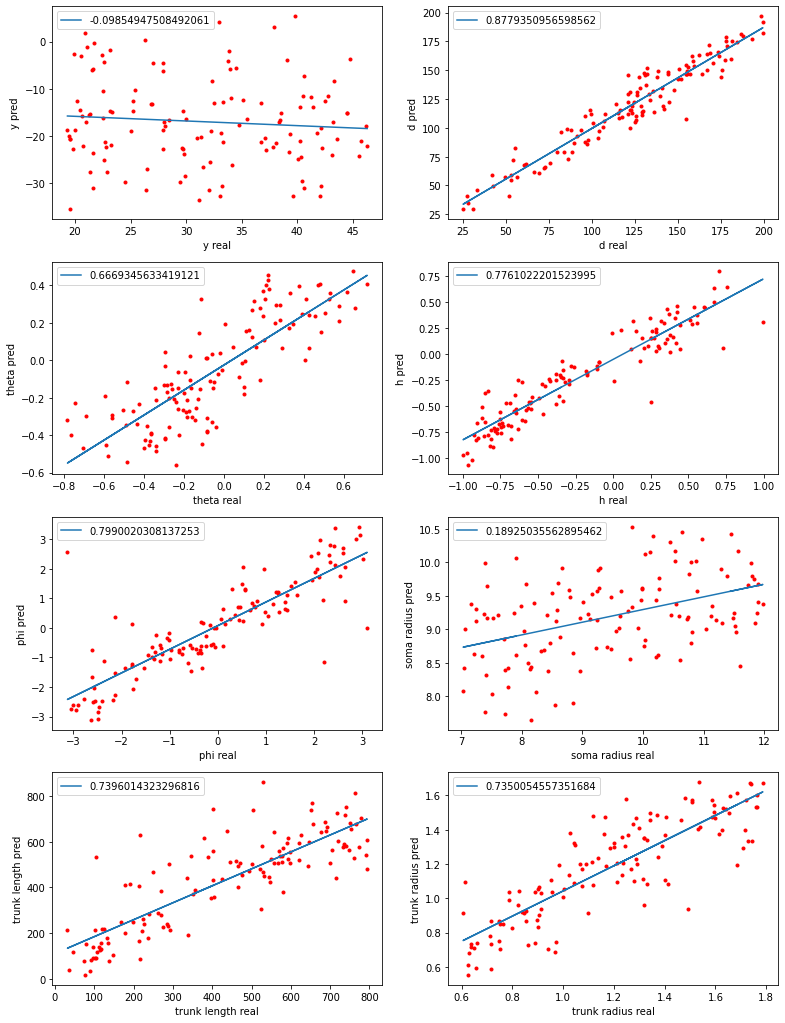

In [17]:
%matplotlib inline

idx = 0

plt.figure(figsize=(13,18))

lab_ax = 0
ax_y = plt.subplot(421)
ax_y.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_y.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_y.set_xlabel('y real')
ax_y.set_ylabel('y pred')
ax_y.legend()

lab_ax = 1
ax_d = plt.subplot(422)
ax_d.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_d.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')
ax_d.legend()

lab_ax = 2
ax_t = plt.subplot(423)
ax_t.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_t.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')
ax_t.legend()

lab_ax = 3
ax_h = plt.subplot(424)
ax_h.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_h.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')
ax_h.legend()

lab_ax = 4
ax_p = plt.subplot(425)
ax_p.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_p.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')
ax_p.legend()

lab_ax = 5
ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_lt.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')
ax_lt.legend()

lab_ax = 6
ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_lt.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')
ax_lt.legend()

lab_ax = 7
ax_lt = plt.subplot(428)
ax_lt.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax_lt.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label=str(m))
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')
ax_lt.legend()


plt.show()

In [10]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window
from tqdm.notebook import tqdm
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    c = f['coord'][:]
    d = f['data'][:]  # time x channels x samples

t = np.arange(d.shape[0])

scaler = 7720.0

filtered_lfp = np.divide(d, scaler)

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(d.shape[2]):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[:,:,i])
    start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[start:end, :, i])

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

print(windowed_lfp.shape)

test_data = []
summ_stats = []
bad_indices = []
y_pos = []
for i in tqdm(range(windowed_lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(windowed_lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        # windowed_lfp = np.delete(windowed_lfp, i, axis=0)
        # self.labels = np.delete(self.labels, i, axis=0)
        bad_indices.append(i)
        continue
    test_data.append(g_lfp)
    summ_stats.append(calculate_stats(g_lfp))
    y_pos.append(y_i)
    
test_data = np.stack(test_data, axis=0)
summ_stats = np.array(summ_stats)
y_pos = np.stack(y_pos, axis=0)

(383, 176, 384)


  0%|          | 0/383 [00:00<?, ?it/s]

In [11]:
y_pos = y_pos.reshape((-1,))
print(y_pos.shape)

np.set_printoptions(suppress=True)

model.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

print(pred[:, 0].shape)

# pred[:,0] = y_pos - pred[:, 0]

print(pred.shape)

if True:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred


y_pred = pred
df = pd.DataFrame(y_pred, columns=inference_list).sort_values(by='y')
# df = df[df['y'].between(-700,700)]
display(df)

(359,)
(359,)
(359, 8)


,y,d,theta,h,phi,r_s,l_t,r_t
189,-54.792953,270.233185,0.000495,-0.418046,0.762987,10.298443,176.177490,0.940726
6,-39.148857,200.351440,0.321755,-0.599367,1.104460,10.073100,385.813904,0.963532
4,-36.615776,202.465469,-0.189670,-0.650201,0.496353,9.744701,403.445465,0.760345
180,-36.584354,175.969238,0.118652,0.386605,-0.653311,10.752549,303.416992,0.997023
21,-35.228424,164.271088,-0.323664,-0.087456,-0.110702,11.002113,135.946198,0.708320
...,...,...,...,...,...,...,...,...
57,-3.896263,55.125778,-0.195823,-0.191453,0.926933,9.642591,522.368164,0.690361
150,-3.477966,55.862797,-0.241462,-0.028428,0.327376,9.495501,430.762878,0.680900
2,-2.765930,89.124908,-0.060041,0.638145,0.049927,7.777655,30.194939,0.878168
141,-2.545883,79.901901,-0.619039,-0.731998,2.931716,8.681799,666.957825,0.595887


In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t
189,-54.792953,270.233185,0.000495,-0.418046,0.762987,10.298443,176.177490,0.940726
6,-39.148857,200.351440,0.321755,-0.599367,1.104460,10.073100,385.813904,0.963532
4,-36.615776,202.465469,-0.189670,-0.650201,0.496353,9.744701,403.445465,0.760345
180,-36.584354,175.969238,0.118652,0.386605,-0.653311,10.752549,303.416992,0.997023
21,-35.228424,164.271088,-0.323664,-0.087456,-0.110702,11.002113,135.946198,0.708320
8,-34.427933,169.141129,-0.205458,-0.509439,-1.436810,10.294905,87.212006,0.795726
337,-32.263306,184.451538,0.268332,0.441270,0.302474,9.889587,480.801453,0.723541
100,-31.357132,174.799179,0.354539,0.506644,-1.222018,9.967865,598.922424,0.947118
198,-30.578766,169.459335,0.115006,0.377678,-0.398026,10.198250,534.662109,0.702816
314,-30.371338,162.352478,0.388463,-0.489996,1.363652,9.911625,347.892395,0.942483


(49, 176)
(49,)
(176,)


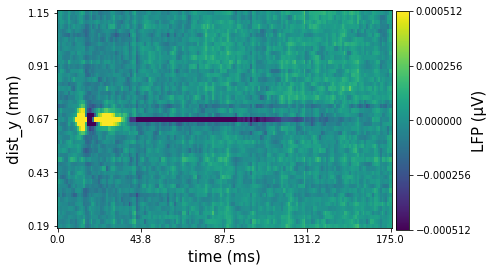

In [13]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

print(test_data[0,:,e_idx].shape)
print(g_coords[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     g_coords[e_idx, 1],
                     np.transpose(test_data[0,:,e_idx]), vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)

/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/utils/plotting/plot_all_cells.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'], df['z'] = pol2cart(df['d'], df['theta'])


<IPython.core.display.Javascript object>


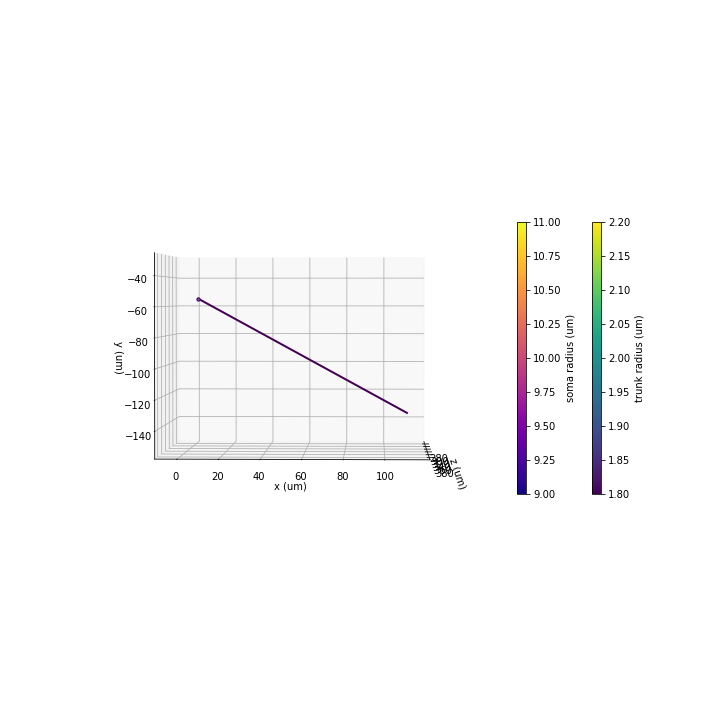

(<Figure size 720x720 with 3 Axes>,
 <Axes3DSubplot:xlabel='z (um)', ylabel='x (um)'>)

In [14]:
%matplotlib notebook

from cell_inference.utils.plotting.plot_all_cells import plot_all_cells

plot_all_cells(df.iloc[[0]], figsize=(10., 10.))